In [1]:
import torch
from torch import nn

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
device = "mps" if torch.backends.mps.is_available() \
    else "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Prepare Data

### Normal Data

In [3]:
Normal_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0],std=[1])
])

In [4]:
# Setup training data
Train_Normal_data = datasets.FashionMNIST(
    root="/kaggle/working", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=Normal_transform, # images come as PIL format, we want to turn into Torch tensors
)
Test_Normal_data = datasets.FashionMNIST(
    root="/kaggle/working", # where to download data to?
    train=False, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=Normal_transform, # images come as PIL format, we want to turn into Torch tensors
)

100%|██████████| 26421880/26421880 [00:01<00:00, 14726150.73it/s]


Extracting /kaggle/working/FashionMNIST/raw/train-images-idx3-ubyte.gz to /kaggle/working/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 296582.17it/s]


Extracting /kaggle/working/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /kaggle/working/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5521282.89it/s]


Extracting /kaggle/working/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /kaggle/working/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 10763846.96it/s]

Extracting /kaggle/working/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /kaggle/working/FashionMNIST/raw



Length of dataset: 60000
Length of dataset: 10000
Shape of one sample: torch.Size([1, 28, 28])


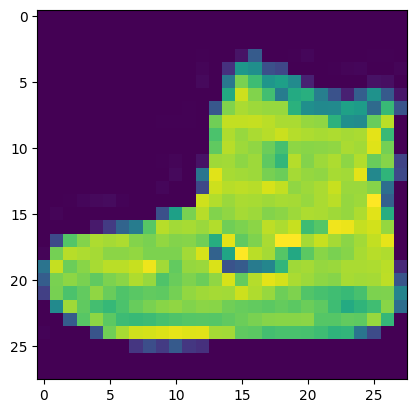

In [5]:
print(f"Length of dataset: {len(Train_Normal_data)}") 
print(f"Length of dataset: {len(Test_Normal_data)}") 
print(f"Shape of one sample: {Train_Normal_data[0][0].shape}")
plt.imshow(Train_Normal_data[0][0].permute(1,2,0))

### Super_Resolution Data

In [6]:
Downscale_transform = transforms.Compose([
    transforms.Resize((14,14)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0],std=[1])
])

In [7]:
Train_Downscaled_data = datasets.FashionMNIST(
    root="/kaggle/working", # where to download data to?
    train=True, # get training data
    download=False, # download data if it doesn't exist on disk
    transform=Downscale_transform, # images come as PIL format, we want to turn into Torch tensors
)
Test_Downscaled_data = datasets.FashionMNIST(
    root="/kaggle/working", # where to download data to?
    train=False, # get training data
    download=False, # download data if it doesn't exist on disk
    transform=Downscale_transform, # images come as PIL format, we want to turn into Torch tensors
)

Length of dataset: 60000
Length of dataset: 10000
Shape of one sample: torch.Size([1, 14, 14])


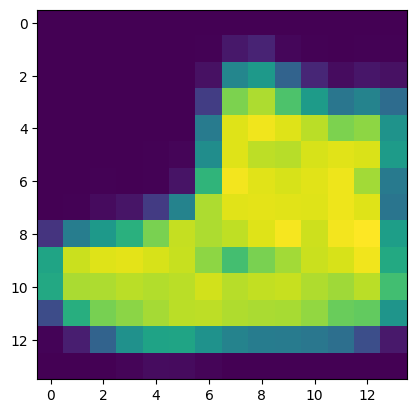

In [8]:
print(f"Length of dataset: {len(Train_Downscaled_data)}") 
print(f"Length of dataset: {len(Test_Downscaled_data)}") 
print(f"Shape of one sample: {Train_Downscaled_data[0][0].shape}")
plt.imshow(Train_Downscaled_data[0][0].permute(1,2,0))

### Denoise Data

In [9]:
class Noisify(object):
    def __call__(self, data):
        # Assuming data is a numpy array
        return (data + np.random.normal(loc=0.2, scale=0.5, size=data.shape)).float()
    
Noise_transform = transforms.Compose([
    transforms.ToTensor(),
    Noisify(),  # Apply the custom Noisify transformation
    transforms.Normalize(mean=[0], std=[1]),  # Normalize the tensor
    
])

In [10]:
Train_Noisy_data = datasets.FashionMNIST(
    root="/kaggle/working", # where to download data to?
    train=True, # get training data
    download=False, # download data if it doesn't exist on disk
    transform=Noise_transform, # images come as PIL format, we want to turn into Torch tensors
)
Test_Noisy_data = datasets.FashionMNIST(
    root="/kaggle/working", # where to download data to?
    train=False, # get training data
    download=False, # download data if it doesn't exist on disk
    transform=Noise_transform, # images come as PIL format, we want to turn into Torch tensors
)

Length of dataset: 60000
Length of dataset: 10000
Shape of one sample: torch.Size([1, 28, 28])


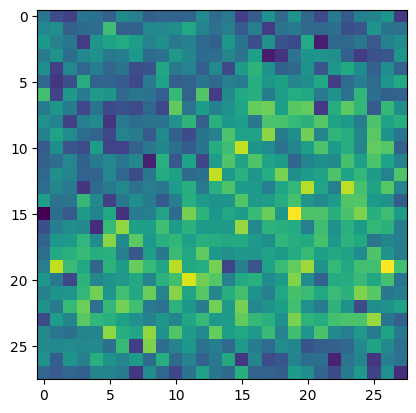

In [11]:
print(f"Length of dataset: {len(Train_Noisy_data)}") 
print(f"Length of dataset: {len(Test_Noisy_data)}") 
print(f"Shape of one sample: {Train_Noisy_data[0][0].shape}")
plt.imshow(Train_Noisy_data[0][0].permute(1,2,0))

# DeNoiser

### Make Dataset

In [12]:
class CombinedDataset(Dataset):
    def __init__(self, dataset1, dataset2):
        self.dataset1 = dataset1
        self.dataset2 = dataset2

        # Ensure the lengths of both datasets are the same
        assert len(dataset1) == len(dataset2)

    def __len__(self):
        return len(self.dataset1)

    def __getitem__(self, index):
        data1 = self.dataset1[index][0]
        data2 = self.dataset2[index][0]

        return (data1, data2)

In [13]:
train_data = CombinedDataset(Train_Noisy_data, Train_Normal_data)
test_data = CombinedDataset(Test_Noisy_data, Test_Normal_data)

Length of dataset: 60000
Length of dataset: 10000
Shape of one sample: torch.Size([1, 28, 28]), torch.Size([1, 28, 28])


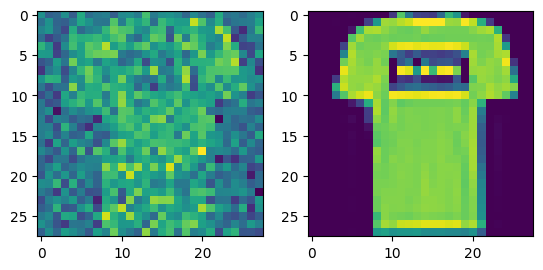

In [14]:
print(f"Length of dataset: {len(train_data)}") 
print(f"Length of dataset: {len(test_data)}") 
print(f"Shape of one sample: {train_data[0][0].shape}, {train_data[0][1].shape}")
fix, ax = plt.subplots(1,2)
ax[0].imshow(train_data[1][0].permute(1,2,0))
ax[1].imshow(train_data[1][1].permute(1,2,0))

### Prepare dataloader

In [15]:
# Setup the batch size hyperparameter
BATCH_SIZE = 128

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch? 
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print(f"Length of training dataset: {len(train_dataloader.dataset)}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataset: {len(test_dataloader.dataset)}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7b83d9ef8310>, <torch.utils.data.dataloader.DataLoader object at 0x7b83d00f5f00>)
Length of training dataset: 60000
Length of train dataloader: 469 batches of 128
Length of test dataset: 10000
Length of test dataloader: 79 batches of 128


In [16]:
batch = next(iter(train_dataloader))
batch[0].shape, batch[1].shape

(torch.Size([128, 1, 28, 28]), torch.Size([128, 1, 28, 28]))

### Model architecture

In [17]:
class DeNoiser(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, 
                      out_channels=16, 
                      kernel_size=(3,3), 
                      padding='same'),
            nn.ReLU(), 
            nn.InstanceNorm2d(16),
            
            nn.Conv2d(in_channels=16, 
                      out_channels=16, 
                      kernel_size=(3,3), 
                      padding='same'),
            nn.ReLU(), 
            nn.InstanceNorm2d(16),
            
            
            nn.MaxPool2d(kernel_size = (2,2)),
            
            
            nn.Conv2d(in_channels=16, 
                      out_channels=16, 
                      kernel_size=(3,3), 
                      padding='same'),
            nn.ReLU(),
            nn.InstanceNorm2d(16),
            
            nn.Conv2d(in_channels=16, 
                      out_channels=16, 
                      kernel_size=(3,3), 
                      padding='same'),
            nn.ReLU(),
            nn.InstanceNorm2d(16),
            
            
            nn.MaxPool2d(kernel_size = (2,2)),

            
            nn.Conv2d(in_channels=16,
                      out_channels=8, 
                      kernel_size=(3,3), 
                      padding='same'),
            nn.ReLU(),
            nn.InstanceNorm2d(8),
            
            nn.Conv2d(in_channels=8,
                      out_channels=8, 
                      kernel_size=(3,3), 
                      padding='same'),
            nn.ReLU(),
            nn.InstanceNorm2d(8),
            
            
            nn.MaxPool2d(kernel_size = (2,2)),
        )
        
        self.decoder = nn.Sequential(
             nn.Conv2d(in_channels=8,
                      out_channels=8, 
                      kernel_size=(3,3), 
                      padding='same'),
            nn.ReLU(),  
            nn.InstanceNorm2d(8),
            
            nn.Conv2d(in_channels=8,
                      out_channels=8, 
                      kernel_size=(3,3), 
                      padding='same'),
            nn.ReLU(),  
            nn.InstanceNorm2d(8),
            
            nn.UpsamplingBilinear2d(size = (7,7)),
            
            nn.Conv2d(in_channels=8,
                      out_channels=8, 
                      kernel_size=(3,3), 
                      padding='same'),
            nn.ReLU(),  
            nn.InstanceNorm2d(8),
            
            nn.Conv2d(in_channels=8,
                      out_channels=8, 
                      kernel_size=(3,3), 
                      padding='same'),
            nn.ReLU(),  
            nn.InstanceNorm2d(8),
            
            
            nn.UpsamplingBilinear2d(scale_factor = 2),
            
            
            nn.Conv2d(in_channels=8,
                      out_channels=16, 
                      kernel_size=(3,3), 
                      padding='same'),
            nn.ReLU(),  
            nn.InstanceNorm2d(16),
            
            nn.Conv2d(in_channels=16,
                      out_channels=16, 
                      kernel_size=(3,3), 
                      padding='same'),
            nn.ReLU(),  
            nn.InstanceNorm2d(16),
            
            
            nn.UpsamplingBilinear2d(scale_factor = 2),
             
            nn.Conv2d(in_channels=16,
                      out_channels=16, 
                      kernel_size=(3,3), 
                      padding='same'),
            nn.ReLU(),  
            nn.InstanceNorm2d(16),
            
            nn.Conv2d(in_channels=16,
                      out_channels=1, 
                      kernel_size=(3,3), 
                      padding='same')
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [18]:
model_0 = DeNoiser()
with torch.no_grad():
    print(model_0(batch[0]).shape)

model_0

torch.Size([128, 1, 28, 28])


DeNoiser(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (8): ReLU()
    (9): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (11): ReLU()
    (12): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(16, 8, kernel_size=(3, 3)

### Train model

In [19]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = 'cpu'):
    
    if device != 'cpu':
        model.to(device)
    
    train_loss = 0
    model.train()
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        
        if device != 'cpu':
            X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        
        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    train_loss /= len(data_loader)
    
    return train_loss

def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device = 'cpu'):
    
    if device != 'cpu':
        model.to(device)

    test_loss = 0
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            if device != 'cpu':
                X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            y_pred = model(X)
            
            # 2. Calculate loss
            test_loss += loss_fn(y_pred, y)
        
        test_loss /= len(data_loader)
    
    return test_loss

In [20]:
from typing import Dict, List, Tuple
from tqdm.auto import tqdm


def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device = 'cpu') -> Dict[str, List]:
    
    # Create empty results dictionary
    results = {
        "Training_Loss": [],
        "Test_Loss": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
            Training_Loss = train_step(
                data_loader=train_dataloader, 
                model=model, 
                loss_fn=loss_fn,
                optimizer=optimizer,
                device=device
            )
            Test_Loss = test_step(
                data_loader=test_dataloader,
                model=model,
                loss_fn=loss_fn,
                device=device
            )
            # Print out what's happening
            print(
                f"Epoch: {epoch} | "
                f"Training_Loss: {Training_Loss:.4f} | "
                f"Test_Loss: {Test_Loss:.4f} | "
            )

            # Update results dictionary
            results["Training_Loss"].append(Training_Loss.item())
            results["Test_Loss"].append(Test_Loss.item())

  # Return the filled results at the end of the epochs
    return results

In [21]:
# Setup loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.01)

In [22]:
# Setup the num_epochs hyperparameter
NUM_EPOCHS = 50

results = train(model=model_0,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=NUM_EPOCHS,
                device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 | Training_Loss: 0.0517 | Test_Loss: 0.0316 | 
Epoch: 1 | Training_Loss: 0.0293 | Test_Loss: 0.0266 | 
Epoch: 2 | Training_Loss: 0.0260 | Test_Loss: 0.0255 | 
Epoch: 3 | Training_Loss: 0.0245 | Test_Loss: 0.0236 | 
Epoch: 4 | Training_Loss: 0.0237 | Test_Loss: 0.0228 | 
Epoch: 5 | Training_Loss: 0.0229 | Test_Loss: 0.0231 | 
Epoch: 6 | Training_Loss: 0.0225 | Test_Loss: 0.0215 | 
Epoch: 7 | Training_Loss: 0.0222 | Test_Loss: 0.0215 | 
Epoch: 8 | Training_Loss: 0.0217 | Test_Loss: 0.0232 | 
Epoch: 9 | Training_Loss: 0.0213 | Test_Loss: 0.0221 | 
Epoch: 10 | Training_Loss: 0.0212 | Test_Loss: 0.0202 | 
Epoch: 11 | Training_Loss: 0.0208 | Test_Loss: 0.0207 | 
Epoch: 12 | Training_Loss: 0.0209 | Test_Loss: 0.0213 | 
Epoch: 13 | Training_Loss: 0.0205 | Test_Loss: 0.0229 | 
Epoch: 14 | Training_Loss: 0.0204 | Test_Loss: 0.0211 | 
Epoch: 15 | Training_Loss: 0.0203 | Test_Loss: 0.0206 | 
Epoch: 16 | Training_Loss: 0.0200 | Test_Loss: 0.0228 | 
Epoch: 17 | Training_Loss: 0.0199 | Test_

### Plot training results

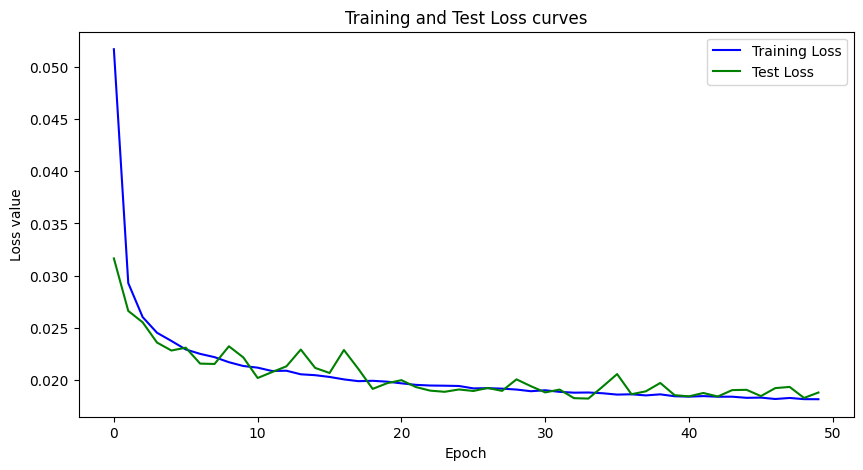

In [23]:
def plot_results(Training_Loss, Test_Loss):
    plt.figure(figsize=(10,5))
    
    plt.plot(Training_Loss, color="blue", label="Training Loss")
    plt.plot(Test_Loss, color="green", label="Test Loss")
    plt.title("Training and Test Loss curves")
    plt.xlabel("Epoch")
    plt.ylabel("Loss value")
    plt.legend()

    plt.show()
    
plot_results(results["Training_Loss"], results["Test_Loss"])

### Test

In [24]:
random_indices = torch.randint(0,10_000, size = [7])
random_indices

tensor([9092, 1541, 7934, 3342, 9650, 8394, 7743])

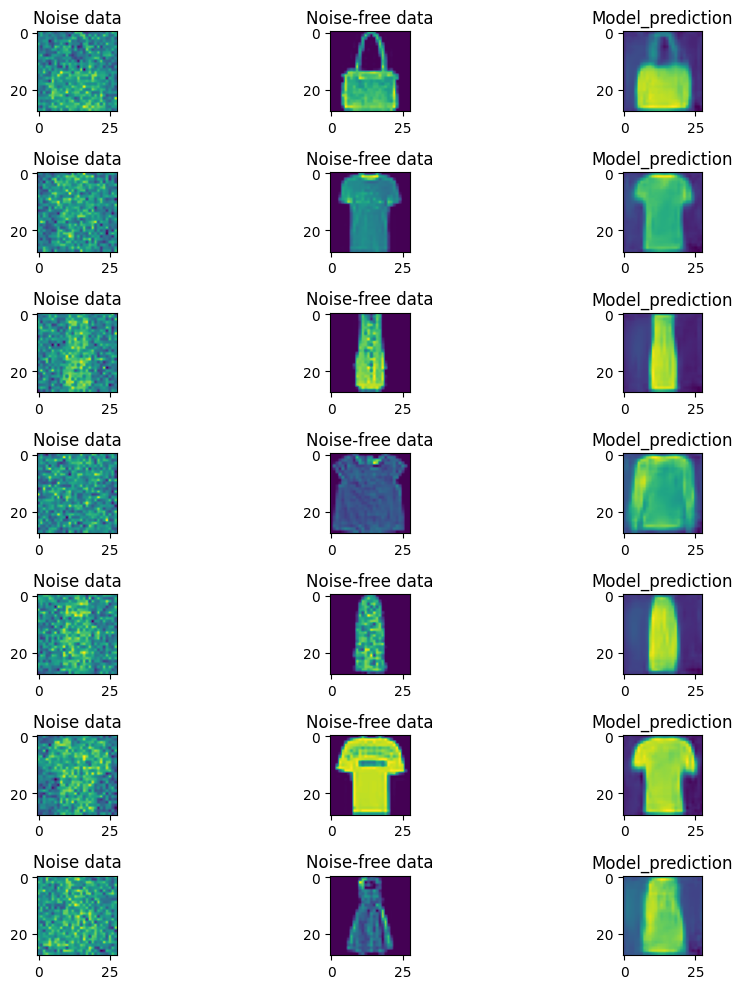

In [25]:
fig, ax = plt.subplots(nrows=7, ncols=3, figsize = (10,10))  
fig.set_facecolor('white')


for i in range(7):
    ax[i][0].imshow(test_data[random_indices[i]][0].permute(1,2,0))
    ax[i][0].set_title('Noise data')
    
    ax[i][1].imshow(test_data[random_indices[i]][1].permute(1,2,0))
    ax[i][1].set_title('Noise-free data')
    
    with torch.no_grad():
        prediction = model_0(test_data[random_indices[i]][0].unsqueeze(0).to(device))
    prediction_np = prediction.cpu().numpy().squeeze(0).transpose(1, 2, 0)
    ax[i][2].imshow(prediction_np)
    ax[i][2].set_title('Model_prediction')
    
plt.tight_layout()

# Super-Resolution

### Make Dataset

In [26]:
train_data = CombinedDataset(Train_Downscaled_data, Train_Normal_data)
test_data = CombinedDataset(Test_Downscaled_data, Test_Normal_data)

Length of dataset: 60000
Length of dataset: 10000
Shape of one sample: torch.Size([1, 14, 14]), torch.Size([1, 28, 28])


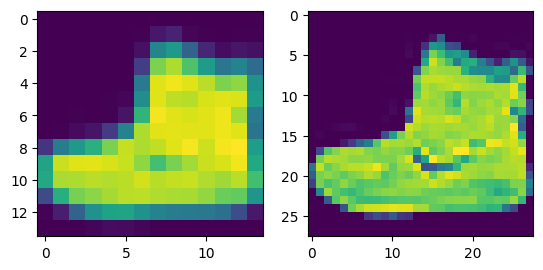

In [27]:
print(f"Length of dataset: {len(train_data)}") 
print(f"Length of dataset: {len(test_data)}") 
print(f"Shape of one sample: {train_data[0][0].shape}, {train_data[0][1].shape}")
fix, ax = plt.subplots(1,2)
ax[0].imshow(train_data[0][0].permute(1,2,0))
ax[1].imshow(train_data[0][1].permute(1,2,0))

### Prepare dataloader

In [28]:
# Setup the batch size hyperparameter
BATCH_SIZE = 128

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch? 
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print(f"Length of training dataset: {len(train_dataloader.dataset)}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataset: {len(test_dataloader.dataset)}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7b83b55c5b70>, <torch.utils.data.dataloader.DataLoader object at 0x7b83b55c6890>)
Length of training dataset: 60000
Length of train dataloader: 469 batches of 128
Length of test dataset: 10000
Length of test dataloader: 79 batches of 128


In [29]:
batch = next(iter(train_dataloader))
batch[0].shape, batch[1].shape

(torch.Size([128, 1, 14, 14]), torch.Size([128, 1, 28, 28]))

### Model Architecture

In [30]:
class SuperResolutionEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, 
                      out_channels=64, 
                      kernel_size=(3,3), 
                      padding='same'),
            nn.ReLU(), 
            nn.InstanceNorm2d(64),
            
            nn.Conv2d(in_channels=64, 
                      out_channels=32, 
                      kernel_size=(3,3), 
                      padding='same'),
            nn.ReLU(), 
            nn.InstanceNorm2d(32),

            nn.MaxPool2d(kernel_size = (2,2)),
            
            nn.Conv2d(in_channels=32, 
                      out_channels=32, 
                      kernel_size=(3,3), 
                      padding='same'),
            nn.ReLU(),
            nn.InstanceNorm2d(32),
            
            nn.Conv2d(in_channels=32, 
                      out_channels=16, 
                      kernel_size=(3,3), 
                      padding='same'),
            nn.ReLU(),
            nn.InstanceNorm2d(16),
            
            nn.MaxPool2d(kernel_size = (2,2)),
            
            nn.Conv2d(in_channels=16, 
                      out_channels=8, 
                      kernel_size=(3,3), 
                      padding='same'),
            nn.ReLU(),
            nn.InstanceNorm2d(8),
            
            nn.Conv2d(in_channels=8, 
                      out_channels=8, 
                      kernel_size=(3,3), 
                      padding='same'),
            nn.ReLU(),
            nn.InstanceNorm2d(8),
            
            nn.MaxPool2d(kernel_size = (2,2))
            
        )
        
        self.decoder = nn.Sequential(
            nn.Conv2d(in_channels=8,
                      out_channels=8, 
                      kernel_size=(3,3), 
                      padding='same'),
            nn.ReLU(),  
            
            nn.Conv2d(in_channels=8,
                      out_channels=8, 
                      kernel_size=(3,3), 
                      padding='same'),
            nn.ReLU(),  
            
            nn.UpsamplingBilinear2d(size = (3,3)),

            nn.Conv2d(in_channels=8,
                      out_channels=16, 
                      kernel_size=(3,3), 
                      padding='same'),
            nn.ReLU(),  
            nn.InstanceNorm2d(16),
            
            nn.Conv2d(in_channels=16,
                      out_channels=16, 
                      kernel_size=(3,3), 
                      padding='same'),
            nn.ReLU(), 
            nn.InstanceNorm2d(16),
            
            nn.UpsamplingBilinear2d(size = (7,7)),

            nn.Conv2d(in_channels=16,
                      out_channels=16, 
                      kernel_size=(3,3), 
                      padding='same'),
            nn.ReLU(),  
            nn.InstanceNorm2d(16),
            
            nn.Conv2d(in_channels=16,
                      out_channels=32, 
                      kernel_size=(3,3), 
                      padding='same'),
            nn.ReLU(), 
            nn.InstanceNorm2d(32),
            
            nn.UpsamplingBilinear2d(scale_factor = 2),

            nn.Conv2d(in_channels=32,
                      out_channels=32, 
                      kernel_size=(3,3), 
                      padding='same'),
            nn.ReLU(),  
            nn.InstanceNorm2d(32),
            
            nn.Conv2d(in_channels=32,
                      out_channels=64, 
                      kernel_size=(3,3), 
                      padding='same'),
            nn.ReLU(),  
            nn.InstanceNorm2d(64),
            
            nn.UpsamplingBilinear2d(scale_factor = 2),
            
            nn.Conv2d(in_channels=64,
                      out_channels=64, 
                      kernel_size=(3,3), 
                      padding='same'),
            nn.ReLU(),  
            nn.InstanceNorm2d(64),
            
            nn.Conv2d(in_channels=64,
                      out_channels=32, 
                      kernel_size=(3,3), 
                      padding='same'),
            nn.ReLU(),  
            nn.InstanceNorm2d(32),
            
            nn.Conv2d(in_channels=32,
                      out_channels=1, 
                      kernel_size=(3,3), 
                      padding='same'),
            
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [31]:
model_1 = SuperResolutionEncoder()
with torch.no_grad():
    print(model_1(batch[0]).shape)
model_1

torch.Size([128, 1, 28, 28])


SuperResolutionEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (8): ReLU()
    (9): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (11): ReLU()
    (12): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(16, 8, kern

In [32]:
# with torch.no_grad():
#     print(model_1(batch[0])[0] == 0)

### Train_model

In [33]:
# Setup loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.01)

In [34]:
# Setup the num_epochs hyperparameter
NUM_EPOCHS = 50

results = train(model=model_1,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=NUM_EPOCHS,
                device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 | Training_Loss: 0.0758 | Test_Loss: 0.0530 | 
Epoch: 1 | Training_Loss: 0.0426 | Test_Loss: 0.0347 | 
Epoch: 2 | Training_Loss: 0.0347 | Test_Loss: 0.0310 | 
Epoch: 3 | Training_Loss: 0.0313 | Test_Loss: 0.0310 | 
Epoch: 4 | Training_Loss: 0.0292 | Test_Loss: 0.0269 | 
Epoch: 5 | Training_Loss: 0.0282 | Test_Loss: 0.0304 | 
Epoch: 6 | Training_Loss: 0.0272 | Test_Loss: 0.0299 | 
Epoch: 7 | Training_Loss: 0.0270 | Test_Loss: 0.0263 | 
Epoch: 8 | Training_Loss: 0.0272 | Test_Loss: 0.0257 | 
Epoch: 9 | Training_Loss: 0.0258 | Test_Loss: 0.0246 | 
Epoch: 10 | Training_Loss: 0.0258 | Test_Loss: 0.0245 | 
Epoch: 11 | Training_Loss: 0.0255 | Test_Loss: 0.0273 | 
Epoch: 12 | Training_Loss: 0.0249 | Test_Loss: 0.0245 | 
Epoch: 13 | Training_Loss: 0.0249 | Test_Loss: 0.0252 | 
Epoch: 14 | Training_Loss: 0.0248 | Test_Loss: 0.0235 | 
Epoch: 15 | Training_Loss: 0.0247 | Test_Loss: 0.0249 | 
Epoch: 16 | Training_Loss: 0.0776 | Test_Loss: 0.0562 | 
Epoch: 17 | Training_Loss: 0.0479 | Test_

### Plot training results

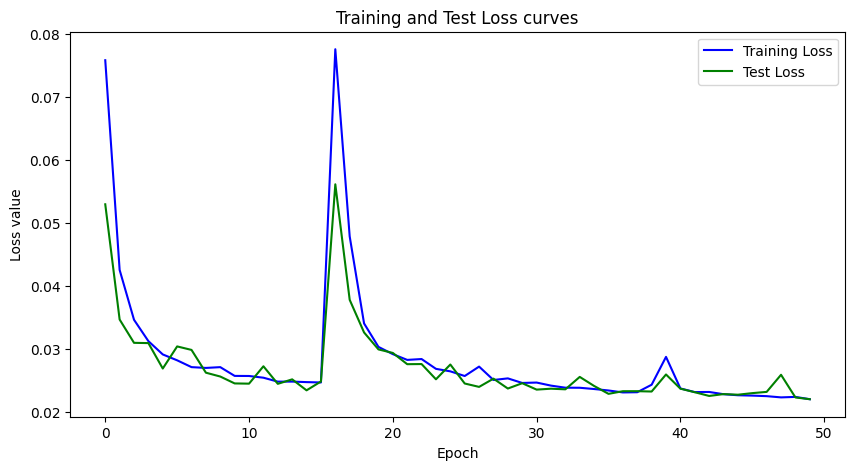

In [35]:
plot_results(results["Training_Loss"], results["Test_Loss"])

### Test

In [36]:
random_indices = torch.randint(0,10_000, size = [7])
random_indices

tensor([ 913,  685, 3893, 3626, 4471, 8658, 2397])

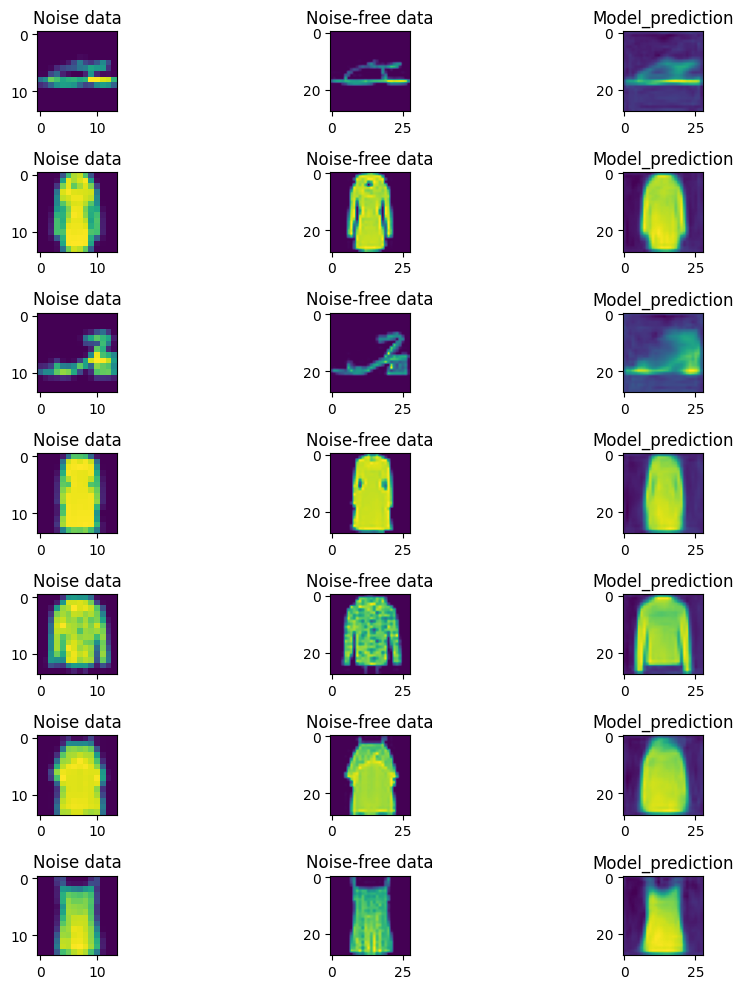

In [37]:
fig, ax = plt.subplots(nrows=7, ncols=3, figsize = (10,10))  
fig.set_facecolor('white')


for i in range(7):
    ax[i][0].imshow(test_data[random_indices[i]][0].permute(1,2,0))
    ax[i][0].set_title('Noise data')
    
    ax[i][1].imshow(test_data[random_indices[i]][1].permute(1,2,0))
    ax[i][1].set_title('Noise-free data')
    
    with torch.no_grad():
        prediction = model_1(test_data[random_indices[i]][0].unsqueeze(0).to(device))
    prediction_np = prediction.cpu().numpy().squeeze(0).transpose(1, 2, 0)
    ax[i][2].imshow(prediction_np)
    ax[i][2].set_title('Model_prediction')
    
plt.tight_layout()